Uses log spectrograms
- No batchnorm
- Weight decay

In [1]:
import json
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from common import datasets as data
from localmlp import layers as lyr
from common import constants as const
from common import tuningcurves as tc


import ipywidgets as widgets
from ipywidgets import interact, interact_manual

# Data

In [26]:
dataset='cochleagram'
data_directory='/data3/hamza/datasets/noisy-speech/spectrograms3/'
# directory='speech'
batch_size=20
shuffle=True

In [27]:
data_iterator = data.DataIterator(dataset=dataset,directory=data_directory,batch_size=batch_size,shuffle=shuffle)

# Save folder

In [30]:
# Figures save folder
fig_save_folder = '/data3/hamza/projects/sparse_music/figs/25b'
if not os.path.exists(fig_save_folder):
    os.mkdir(fig_save_folder)
    print(f'created folder {fig_save_folder}')
else:
    print(f'folder already exists: {fig_save_folder}')



folder already exists: /data3/hamza/projects/sparse_music/figs/25b


In [31]:
# Model save folder
model_directory = "/home/hamza/data3/projects/sparse_music/experiments/25b"
if not os.path.exists(model_directory):
    os.mkdir(model_directory)
    print(f'created folder {model_directory}')
else:
    print(f'folder already exists: {model_directory}')

folder already exists: /home/hamza/data3/projects/sparse_music/experiments/25b


## Auto-encoder

## Load models?
Uncomment following and skip model definition and training

In [33]:
encoder = torch.load(os.path.join(model_directory,"encoder.pt"))
decoder = torch.load(os.path.join(model_directory,"decoder.pt"))


In [9]:
class Encoder(nn.Module):
    def __init__(self,channels,kernel_sizes=[(31,1)],strides = [(3,1)]):
        super(Encoder,self).__init__()
        self.layers = nn.ModuleList()
        for i in range(len(kernel_sizes)):
            self.layers.append(nn.Conv2d(in_channels=channels[i],out_channels=channels[i+1],kernel_size=kernel_sizes[i],stride = strides[i]))
        self.channels = channels
        self.kernel_sizes = kernel_sizes
        self.strides = strides
        
            
    def forward(self,x):
        out = x
        for i in range(len(self.layers)):
            out = self.layers[i](out)
        return out
    
class Decoder(nn.Module):
    def __init__(self,channels,kernel_sizes=[(31,1)],strides = [(3,1)]):
        super(Decoder,self).__init__()
        self.layers = nn.ModuleList()
        for i in range(len(kernel_sizes)):
            self.layers.append(nn.ConvTranspose2d(in_channels=channels[i],out_channels=channels[i+1],kernel_size=kernel_sizes[i],stride = strides[i]))
        self.channels = channels
        self.kernel_sizes = kernel_sizes
        self.strides = strides
        
            
    def forward(self,x):
        out = x
        for i in range(len(self.layers)):
            out = self.layers[i](out)
        return out

In [10]:
channels = [1,64,64,64,64]

# 24 coponents per octave contain 2 octaves in filter: 48
kernel_sizes = [(18,1),(18,1),(18,1),(18,1)]
strides = [(2,1),(2,1),(1,1),(1,1)]

device = torch.device('cuda:7')

encoder = Encoder(channels = channels,kernel_sizes = kernel_sizes,strides=strides).to(device)
decoder = Decoder(channels= channels[::-1],kernel_sizes = kernel_sizes[::-1],strides=strides[::-1]).to(device)

In [21]:
def add_noise(x,proportion=0.25):
    y = x.clone()
    y[...,torch.rand(x.shape[-2:]) < proportion] = 0
    return y

## Loss definition

In [11]:
bce_loss = nn.BCELoss(reduction = 'none')

### Weighted bce version, weights active units higher than silent units of the cochleagram

In [14]:
def w_bce_loss(out,target, threshold = 0.3, weights = [1,40]):
    n0 = (target<=0.3).sum()
    n1 = (target>0.3).sum()
    l0 = weights[0] * bce_loss(out[target<=0.3],target[target<=0.3]).sum()
    l1 = weights[1] * bce_loss(out[target>0.3],target[target>0.3]).sum()
    return (l0 + l1) / (n0*weights[0] + n1*weights[1])

In [15]:
def L1loss(x):
    return torch.mean(torch.abs(x))

In [16]:
def sparsity_loss(activations,level = 0.05):
#     return torch.mean(torch.abs(torch.mean(torch.abs(activations),axis=1) - 0.05))
    rho_hat = torch.mean(torch.abs(activations),axis = 0)
    gap = (rho_hat - level)**2
    loss = torch.mean(gap)
    return loss

## Optimizer

In [17]:
params = list(encoder.parameters()) + list(decoder.parameters())
optimizer = optim.Adam(params, lr=0.001,weight_decay = 1e-5)

# Training

In [18]:
r_losses = []
l1_losses = []
losses = []

In [22]:
encoder.train()
decoder.train()
for epoch in range(10):
    for i, elem in enumerate(data_iterator.loader):

        optimizer.zero_grad()
        x = elem.type(torch.FloatTensor).unsqueeze(1).to(device)
        M = x.max(axis=-1).values.max(axis=-1).values[:,None,None]
        m = x.min(axis=-1).values.min(axis=-1).values[:,None,None]
        x = (x-m)/(M-m)
        x = x[...,:232,:]
        
        x_hat = add_noise(x,proportion=0.50)
        
        code = encoder.layers[0](x_hat)     
    #     code = torch.relu(code)

        code = encoder.layers[1](code)
        code = torch.relu(code)

        code = encoder.layers[2](code)
    #     code = torch.relu(code)

        code = encoder.layers[3](code)
        code = torch.relu(code)



        out = decoder.layers[0](code)
        out = torch.relu(out)

        out = decoder.layers[1](out)
        out = torch.relu(out)

        out = decoder.layers[2](out)
        out = torch.relu(out)

        out = decoder.layers[3](out)
        out = torch.sigmoid(out)

        
        r_loss = w_bce_loss(out,x,weights=[1,5])
        r_loss.backward()
        optimizer.step()
        r_losses.append(r_loss.item())
        if i % 10 ==0:
            print(f"epoch {epoch} iteration {i}: R Loss = {np.mean(r_losses[-50:])}")

epoch 0 iteration 0: R Loss = 0.7144162058830261
epoch 0 iteration 10: R Loss = 0.49525445157831366
epoch 0 iteration 20: R Loss = 0.4045914865675427
epoch 0 iteration 30: R Loss = 0.36169120284818834
epoch 0 iteration 40: R Loss = 0.3358677098663842
epoch 0 iteration 50: R Loss = 0.3108880868554115
epoch 0 iteration 60: R Loss = 0.26331333369016646
epoch 0 iteration 70: R Loss = 0.2490394365787506
epoch 0 iteration 80: R Loss = 0.23934098452329636
epoch 0 iteration 90: R Loss = 0.23261797457933425
epoch 0 iteration 100: R Loss = 0.2266201514005661
epoch 0 iteration 110: R Loss = 0.22309069365262985
epoch 0 iteration 120: R Loss = 0.22040574193000795
epoch 0 iteration 130: R Loss = 0.21951796740293503
epoch 0 iteration 140: R Loss = 0.2169538789987564
epoch 0 iteration 150: R Loss = 0.21738939076662064
epoch 0 iteration 160: R Loss = 0.2168851089477539
epoch 0 iteration 170: R Loss = 0.21533820539712906
epoch 0 iteration 180: R Loss = 0.21274228751659394
epoch 0 iteration 190: R Loss =

KeyboardInterrupt: 

In [36]:
encoder = encoder.eval()
decoder = decoder.eval()
with torch.no_grad():
    code = encoder.layers[0](x_hat)     
#     code = torch.relu(code)

    code = encoder.layers[1](code)
    code = torch.relu(code)

    code = encoder.layers[2](code)
#     code = torch.relu(code)

    code = encoder.layers[3](code)
    code = torch.relu(code)



    out = decoder.layers[0](code)
    out = torch.relu(out)

    out = decoder.layers[1](out)
    out = torch.relu(out)

    out = decoder.layers[2](out)
    out = torch.relu(out)

    out = decoder.layers[3](out)
    out = torch.sigmoid(out)

## Careful! Do not run this unless you are sure you are not overwriting a good model.

In [34]:
# torch.save(encoder,os.path.join(model_directory,"encoder.pt"))
# torch.save(decoder,os.path.join(model_directory,"decoder.pt"))


In [37]:
@interact
def viz_in_out(i=(0,x.shape[0]-1,1)):
    
    f, axarr = plt.subplots(1,2,figsize=(10,12))
    axarr[0].imshow(x_hat[i][0].cpu().numpy(),vmax=1,cmap='gray')
    axarr[0].set_title('Original')
    axarr[1].imshow(out[i][0].pow(1).cpu().numpy(),vmax=1,cmap='gray')# / out[i].cpu().numpy().max())
    axarr[1].set_title('recovered')
#     axarr[2].colorbar()
    plt.savefig(os.path.join(fig_save_folder,f'0-noise-added{i}.pdf'))
#     axarr[0].imshow(x_hat[i][0].cpu().numpy())
#     axarr[1].imshow(out[i][0].cpu().numpy())# / out[i].cpu().numpy().max())
    print(x[i].max())
    print(out[i].max())

interactive(children=(IntSlider(value=9, description='i', max=19), Output()), _dom_classes=('widget-interact',…

# Sparsity

In [31]:
responses = [[] for i in range(4)]

encoder = encoder.eval()
decoder = decoder.eval()
with torch.no_grad():
    
    for i, elem in enumerate(data_iterator.loader):

        x = elem.type(torch.FloatTensor).unsqueeze(1).to(device)
        M = x.max(axis=-1).values.max(axis=-1).values[:,None,None]
        m = x.min(axis=-1).values.min(axis=-1).values[:,None,None]
        x = (x-m)/(M-m)
        x = x[...,:232,:100]

        code = encoder.layers[0](x)     
    #     code = torch.relu(code)
        responses[0].append(code.cpu().numpy())

        code = encoder.layers[1](code)
        code = torch.relu(code)
        responses[1].append(code.cpu().numpy())


        code = encoder.layers[2](code)
    #     code = torch.relu(code)
        responses[2].append(code.cpu().numpy())


        code = encoder.layers[3](code)
        code = torch.relu(code)
        responses[3].append(code.cpu().numpy())
        if i == 100:
            break


#         out = decoder.layers[0](code)
#         out = torch.relu(out)

#         out = decoder.layers[1](out)
#         out = torch.relu(out)

#         out = decoder.layers[2](out)
#         out = torch.relu(out)

#         out = decoder.layers[3](out)
#         out = torch.sigmoid(out)

In [32]:
len(responses[0])

101

In [25]:
x.shape

torch.Size([20, 1, 232, 251])

In [33]:
responses = [np.concatenate(responses[i],axis=0) for i in range(4)]

In [34]:
def gini(array):
    """Calculate the Gini coefficient of a numpy array."""
    # based on bottom eq: http://www.statsdirect.com/help/content/image/stat0206_wmf.gif
    # from: http://www.statsdirect.com/help/default.htm#nonparametric_methods/gini.htm
    array = array.flatten() #all values are treated equally, arrays must be 1d
    if np.amin(array) < 0:
        array -= np.amin(array) #values cannot be negative
    array += 0.0000001 #values cannot be 0
    array = np.sort(array) #values must be sorted
    index = np.arange(1,array.shape[0]+1) #index per array element
    n = array.shape[0]#number of array elements
    return ((np.sum((2 * index - n  - 1) * array)) / (n * np.sum(array))) #Gini coefficient

In [38]:
gini_per_layer = [gini(np.abs(responses[i][:50])) for i in range(4)]


Text(0, 0.5, 'Gini index')

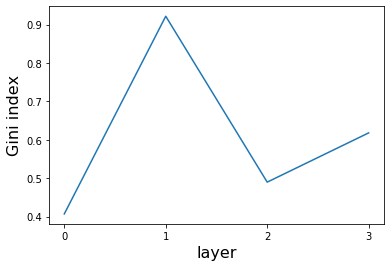

In [59]:
plt.plot(gini_per_layer)
plt.xlabel('layer',fontsize =16)
plt.xticks([0,1,2,3])
plt.ylabel('Gini index',fontsize=16)

In [40]:
gini_per_layer

[0.40683582845717825,
 0.92186596590286,
 0.48964505551998483,
 0.6179582345854318]

In [30]:
np.concatenate(responses[0].cpu().numpy(),0).shape

AttributeError: 'list' object has no attribute 'cpu'

# PT Responses

In [41]:
directory = '/data3/hamza/datasets/synthesized_tones/pt_logspec/'
dataloader = data.DataIterator(dataset = 'frequencies',batch_size = 100,directory = directory,shuffle=False)

In [104]:
resp_code = [[] for i in range(4)]
frequencies = [] 
outs = []
outs2 = []
ins = []

encoder.eval()
decoder.eval()

with torch.no_grad():
    for i,(x,freqs) in enumerate(dataloader.loader):
        print(i)
    #     cgrams = cgrams.unsqueeze(1)
        x = x.type(torch.FloatTensor).unsqueeze(1).to(device)
        x = x[...,:232,20:25]
        M = x.max(axis=2).values.max(axis=1).values[:,None,None]
        m = x.min(axis=2).values.min(axis=1).values[:,None,None]
        x = (x-m)/(M-m)
        print(x.shape)
        
        code = encoder.layers[0](x)     
        #     code = torch.relu(code)
        resp_code[0].append(code[...,0].cpu().data.numpy())

        code = encoder.layers[1](code)
        code = torch.relu(code)
        resp_code[1].append(code[...,0].cpu().data.numpy())

        
        code = encoder.layers[2](code)
        #     code = torch.relu(code)
        resp_code[2].append(code[...,0].cpu().data.numpy())

        
        
        code = encoder.layers[3](code)
        code = torch.relu(code)
        resp_code[3].append(code[...,0].cpu().data.numpy())


        out = decoder.layers[0](code)
        out = torch.relu(out)

        out = decoder.layers[1](out)
        out = torch.relu(out)
    
        outs.append(out[...,0].cpu().data.numpy())
        
        out = decoder.layers[2](out)
        out = torch.relu(out)

        out = decoder.layers[3](out)
        out = torch.sigmoid(out)
        
        outs2.append(out[...,0].cpu().data.numpy())
        
        
        ins.append(x[...,0].cpu().data.numpy())

#         resp_code.append(code[...,0].cpu().data.numpy())
        frequencies.append(freqs)
        if i == 40 :
            break

            
s = np.vstack(ins)       

s = np.moveaxis(s,0,-1)

r = [np.moveaxis(np.vstack(resp_code[i]),0,-1) for i in range(4)]
o = np.vstack(outs)
o2 = np.vstack(outs2)

freqs = np.concatenate(frequencies)

# r = np.moveaxis(r,0,-1)
o = np.moveaxis(o,0,-1)
o2 = np.moveaxis(o2,0,-1)


0
torch.Size([100, 1, 232, 5])
1
torch.Size([100, 1, 232, 5])
2
torch.Size([100, 1, 232, 5])
3
torch.Size([100, 1, 232, 5])
4
torch.Size([100, 1, 232, 5])
5
torch.Size([100, 1, 232, 5])
6
torch.Size([100, 1, 232, 5])
7
torch.Size([100, 1, 232, 5])
8
torch.Size([100, 1, 232, 5])
9
torch.Size([100, 1, 232, 5])
10
torch.Size([100, 1, 232, 5])
11
torch.Size([100, 1, 232, 5])
12
torch.Size([100, 1, 232, 5])
13
torch.Size([100, 1, 232, 5])
14
torch.Size([100, 1, 232, 5])
15
torch.Size([100, 1, 232, 5])
16
torch.Size([100, 1, 232, 5])
17
torch.Size([100, 1, 232, 5])
18
torch.Size([100, 1, 232, 5])
19
torch.Size([100, 1, 232, 5])
20
torch.Size([100, 1, 232, 5])
21
torch.Size([100, 1, 232, 5])
22
torch.Size([100, 1, 232, 5])
23
torch.Size([100, 1, 232, 5])
24
torch.Size([100, 1, 232, 5])
25
torch.Size([100, 1, 232, 5])
26
torch.Size([100, 1, 232, 5])
27
torch.Size([100, 1, 232, 5])
28
torch.Size([100, 1, 232, 5])
29
torch.Size([100, 1, 232, 5])
30
torch.Size([100, 1, 232, 5])
31
torch.Size([100

In [213]:
r.shape

(64, 12, 2100)

In [108]:
@interact
def scat_plot(layer = (0,3,1), channel = (0,r[0].shape[0]-1,1),pos=(0,r[0].shape[1]-1,1)):
    plt.figure()
    maxf=2000
    plt.plot(freqs[:maxf],r[layer][channel,pos][:maxf],label = 'tuning curve')
#     plt.plot(freqs[:maxf],r[layer][channel,pos][:maxf].max()*p[channel,pos][:maxf],alpha = 0.5,label = 'peaks')

#     plt.axis([None, None, m, M])

#     plt.title(f'band {pos}/{layers[-1].n_bands} channel {channel}/{r.shape[0]} response')
#     plt.title(f'channel {channel}/{r.shape[0]} response\n Peaks at {freqs[p[channel,pos]]}')

    plt.title('channel {channel}/{r[layer].shape[0]} response\n Peaks at {freqs[:maxf][p[channel,pos][:maxf]]}')
    plt.xlabel(f'frequencies',fontsize=16)
    plt.ylabel('response',fontsize=16)
    plt.legend()

interactive(children=(IntSlider(value=1, description='layer', max=3), IntSlider(value=31, description='channel…

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [34]:
@interact
def scat_plot(channel = (0,o.shape[0]-1,1),pos=(0,o.shape[1]-1,1)):
    plt.figure()
    plt.plot(freqs[:],o[channel,pos,:])
#     plt.plot(freqs[:150],s[channel,:150])
    
    
#     plt.axis([None, None, 0, 1])

    plt.title(f'channel {channel}/{o.shape[0]} response')
    plt.xlabel(f'frequencies')
    plt.ylabel('response')

interactive(children=(IntSlider(value=31, description='channel', max=63), IntSlider(value=22, description='pos…

In [110]:
p=[None for i in range(4)]
rat=[None for i in range(4)]

Text(0, 0.5, 'Count')

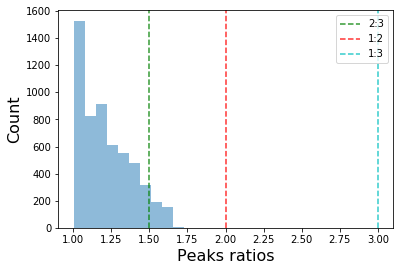

In [159]:
l = 0
p[l] =  tc.peaks_bandwidth(r[l],n=15,m = 12,level=0.8)
p[l] &= r[l]>0.2
rat[l] = tc.all_peaks_ratios(p[l],freqs,max_n_peaks = 20)
tc.plot_ratios_histogram(1/rat[l][1/rat[l]<3.3],bins=10,r=[2,3,5])
len(rat[l])
plt.xlabel('Peaks ratios',fontsize=16)
plt.ylabel('Count',fontsize=16)
# plt.savefig(os.path.join(fig_save_folder,"79-code-ratios-distrib-speechlogspec5.pdf"))

Text(0, 0.5, 'Count')

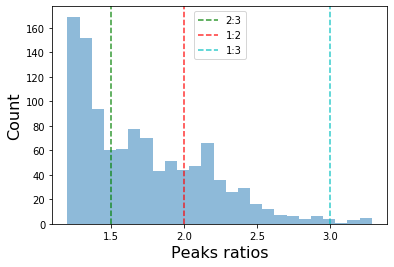

In [134]:
l = 1
p[l] =  tc.peaks_bandwidth(r[l],n=30,m = 15,level=0.8)
p[l] &= r[l]>0.2
rat[l] = tc.all_peaks_ratios(p[l],freqs,max_n_peaks = 20)
tc.plot_ratios_histogram(1/rat[l][(1/rat[l]<3.3) & (1/rat[l]>1.2)],bins=25,r=[2,3,5])
len(rat[l])
plt.xlabel('Peaks ratios',fontsize=16)
plt.ylabel('Count',fontsize=16)
# plt.savefig(os.path.join(fig_save_folder,"79-code-ratios-distrib-speechlogspec5.pdf"))

Text(0, 0.5, 'Count')

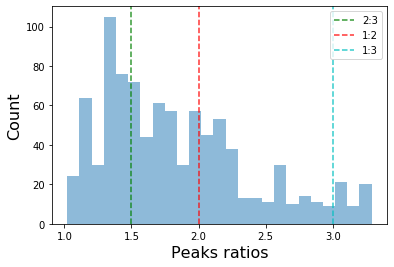

In [133]:
l = 2
p[l] =  tc.peaks_bandwidth(r[l],n=35,m = 30,level=0.7)
p[l] &= r[l]>0.2
rat[l] = tc.all_peaks_ratios(p[l],freqs,max_n_peaks = 20)
tc.plot_ratios_histogram(1/rat[l][1/rat[l]<3.3],bins=25,r=[2,3,5])
len(rat[l])
plt.xlabel('Peaks ratios',fontsize=16)
plt.ylabel('Count',fontsize=16)
# plt.savefig(os.path.join(fig_save_folder,"79-code-ratios-distrib-speechlogspec5.pdf"))

Text(0, 0.5, 'Count')

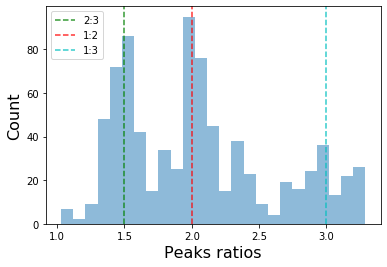

In [135]:
l = 3
p[l] =  tc.peaks_bandwidth(r[l],n=50,m = 45,level=0.8)
p[l] &= r[l]>0.4
rat[l] = tc.all_peaks_ratios(p[l],freqs,max_n_peaks = 20)
tc.plot_ratios_histogram(1/rat[l][1/rat[l]<3.3],bins=25,r=[2,3,5])
len(rat[l])
plt.xlabel('Peaks ratios',fontsize=16)
plt.ylabel('Count',fontsize=16)
# plt.savefig(os.path.join(fig_save_folder,"79-code-ratios-distrib-speechlogspec5.pdf"))

In [232]:
@interact
def plot_out(f=(0,freqs.shape[0],1)):
    plt.plot(s[0,:,f],label='input',color='k',linestyle='dashed')
    plt.plot(o2[0,:,f],label='output',color='k')
    plt.xlabel('log spectrogram position')
    plt.ylabel('activation level')
    plt.legend()
    plt.savefig(os.path.join(fig_save_folder,f"4b-spectrum_completion-frequency{f}.pdf"))

interactive(children=(IntSlider(value=1050, description='f', max=2100), Output()), _dom_classes=('widget-inter…

Should only consider the position that is the most activated for a channel?

# MF response

In [60]:
directory_mf = '/data3/hamza/datasets/synthesized_tones/mf234_logspec10/'
dataloader_mf = data.DataIterator(dataset = 'frequencies',batch_size = 100,directory = directory_mf,shuffle=False)

In [67]:
resp_code = []
frequencies = [] 
outs = []
ins = []

encoder.eval()
decoder.eval()

with torch.no_grad():
    for i,(x,freqs) in enumerate(dataloader_mf.loader):
        print(i)
    #     cgrams = cgrams.unsqueeze(1)
        x = x.type(torch.FloatTensor).unsqueeze(1).to(device)
        x = x[...,:232,20:25]
        M = x.max(axis=2).values.max(axis=1).values[:,None,None]
        m = x.min(axis=2).values.min(axis=1).values[:,None,None]
        x = (x-m)/(M-m)
        print(x.shape)
        
        code = encoder.layers[0](x)     
        #     code = torch.relu(code)

        code = encoder.layers[1](code)
        code = torch.relu(code)

        code = encoder.layers[2](code)
        #     code = torch.relu(code)

        code = encoder.layers[3](code)
        code = torch.relu(code)
        
        
        out = torch.relu(decoder.layers[0](code))
        out = torch.relu(decoder.layers[1](out))
        outs.append(out[...,0].cpu().data.numpy())

        out = torch.relu(decoder.layers[2](out))
        out = torch.sigmoid(decoder.layers[3](out))
        outs2.append(out[...,0].cpu().data.numpy())
        
        
        ins.append(x[...,0].cpu().data.numpy())

        resp_code.append(code[...,0].cpu().data.numpy())
        frequencies.append(freqs)
        if i==20:
            break

s_mf = np.vstack(ins)       
r_mf = np.vstack(resp_code)
o_mf = np.vstack(outs)

freqs = np.concatenate(frequencies)

s_mf = np.moveaxis(s_mf,0,-1)
r_mf = np.moveaxis(r_mf,0,-1)
o_mf = np.moveaxis(o_mf,0,-1)


0
torch.Size([100, 1, 232, 5])
1
torch.Size([100, 1, 232, 5])
2
torch.Size([100, 1, 232, 5])
3
torch.Size([100, 1, 232, 5])
4
torch.Size([100, 1, 232, 5])
5
torch.Size([100, 1, 232, 5])
6
torch.Size([100, 1, 232, 5])
7
torch.Size([100, 1, 232, 5])
8
torch.Size([100, 1, 232, 5])
9
torch.Size([100, 1, 232, 5])
10
torch.Size([100, 1, 232, 5])
11
torch.Size([100, 1, 232, 5])
12
torch.Size([100, 1, 232, 5])
13
torch.Size([100, 1, 232, 5])
14
torch.Size([100, 1, 232, 5])
15
torch.Size([100, 1, 232, 5])
16
torch.Size([100, 1, 232, 5])
17
torch.Size([100, 1, 232, 5])
18
torch.Size([100, 1, 232, 5])
19
torch.Size([100, 1, 232, 5])
20
torch.Size([100, 1, 232, 5])


In [68]:
o2_mf = np.vstack(outs2)

o2_mf = np.moveaxis(o2_mf,0,-1)


In [64]:
s_mf.shape

(1, 232, 2100)

In [142]:
f_pos = 20*(2**(1/24))**np.arange(240)

In [145]:
np.where((f_pos>140-5)&(f_pos<140+5))

(array([67, 68]),)

In [148]:
np.round(24*np.log2(267/20))

90.0

In [158]:
@interact
def plot_out(f=(0,freqs.shape[0],1)):
    plt.axvline(np.round(24*np.log2(f/20))+1,alpha=0.7,label='f_0')

    plt.plot(s_mf[0,:,f],label='input',color='k',linestyle='dashed')
    plt.plot(o2_mf[0,:,f],label='output',color='k')
    plt.xlabel('log spectrogram position',fontsize=16)
    plt.ylabel('activation level',fontsize=16)
    plt.title(f'Missing Fundamental reconstruction f_0 = {f}Hz')
    plt.legend()
#     plt.savefig(os.path.join(fig_save_folder,f"4b-spectrum_completion-frequency_mf{f}.pdf"))

interactive(children=(IntSlider(value=2050, description='f', max=4100), Output()), _dom_classes=('widget-inter…

In [70]:
@interact
def scat_plot(channel = (0,r_mf.shape[0]-1,1),pos=(0,r_mf.shape[1]-1,1)):
    plt.figure()
    maxf = 1000
    plt.plot(freqs[:maxf],r_mf[channel,pos,:maxf],label='MF tuning curve')
    plt.plot(freqs[:maxf],r[channel,pos,:maxf],label='PT tuning curve')
    
#     plt.axis([None, None, m, M])

    plt.title(f'channel {channel}/{r.shape[0]} response')
    plt.xlabel(f'frequencies')
    plt.ylabel('response')
    plt.legend()

interactive(children=(IntSlider(value=31, description='channel', max=63), IntSlider(value=5, description='pos'…

In [80]:
@interact
def scat_plot(channel = (0,r_mf.shape[0]-1,1),pos=(0,r_mf.shape[1]-1,1)):
    plt.figure()
    maxf = 1000
    plt.plot(freqs[:maxf],r_mf[channel,pos,:maxf],label='MF tuning curve',color = 'blue',alpha = 0.5,linestyle = '--')
    plt.plot(freqs[:maxf],p_mf[channel,pos,:maxf],label='MF peaks',color = 'blue')
    
    plt.plot(freqs[:maxf],r[channel,pos,:maxf],label='PT tuning curve',alpha = 0.5,color = 'black',linestyle = '--')
    plt.plot(freqs[:maxf],p[channel,pos,:maxf],label='PT peaks',color = 'black')
    
#     plt.axis([None, None, m, M])

    plt.title(f'channel {channel}/{r.shape[0]} response')
    plt.xlabel(f'frequencies')
    plt.ylabel('response')
    plt.legend()
    print((p_mf[channel,pos,:maxf] * p[channel,pos,:maxf]).sum())

interactive(children=(IntSlider(value=31, description='channel', max=63), IntSlider(value=5, description='pos'…

In [93]:
@interact
def plot(i = (0,sp_pos.shape[0]-1,1 )):

    maxf = 1000
    plt.plot(freqs[:maxf],r_mf[tuple(sp_pos[i])][:maxf],label='MF tuning curve',color = 'blue',alpha = 0.5,linestyle = '--')
    plt.plot(freqs[:maxf],p_mf[tuple(sp_pos[i])][:maxf],label='MF peaks',color = 'blue')
    
    plt.plot(freqs[:maxf],r[tuple(sp_pos[i])][:maxf],label='PT tuning curve',alpha = 0.5,color = 'black',linestyle = '--')
    plt.plot(freqs[:maxf],p[tuple(sp_pos[i])][:maxf],label='PT peaks',color = 'black')
    print(freqs[:maxf][p[tuple(sp_pos[i])][:maxf]])
    plt.legend()

interactive(children=(IntSlider(value=99, description='i', max=199), Output()), _dom_classes=('widget-interact…

In [83]:
np.where(p_mf[...,:2000] * p[...,:2000])

(array([ 1,  3,  5,  5,  5,  5, 10, 14, 14, 14, 16, 16, 26, 26, 26, 39, 45,
        45, 50, 51, 51]),
 array([ 3,  8,  2,  3,  4,  5,  6,  8,  9, 10,  8,  8,  6, 10, 11,  1, 10,
        11,  8,  4,  6]),
 array([167, 449,  65,  74,  84,  95, 213, 167, 189, 213, 334, 678, 131,
         57,  65, 271, 148, 167,  79, 105, 135]))

In [54]:
@interact
def plot(i = (0,r_sp.shape[0],1)):
    plt.figure()
    maxf = 1000
    plt.plot(freqs[:maxf],r_sp[i,:maxf],label='PT tuning curve')
    plt.plot(freqs[:maxf],p_sp[i,:maxf],label='peak')
    plt.plot(freqs[:maxf],r_mf_sp[i,:maxf],label='MF tuning curve')
    plt.legend()

interactive(children=(IntSlider(value=77, description='i', max=155), Output()), _dom_classes=('widget-interact…

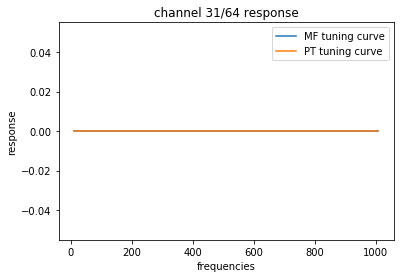

In [246]:
@interact
def scat_plot(channel = (0,o_mf.shape[0]-1,1),pos=(0,o_mf.shape[1]-1,1)):
    plt.figure()
    maxf = 1000
    plt.plot(freqs[:maxf],o_mf[channel,pos,:maxf],label='MF tuning curve')
    plt.plot(freqs[:maxf],o[channel,pos,:maxf],label='PT tuning curve')
    
#     plt.axis([None, None, m, M])

    plt.title(f'channel {channel}/{r.shape[0]} response')
    plt.xlabel(f'frequencies')
    plt.ylabel('response')
    plt.legend()

In [110]:
argmax = o.max(axis = -1).argmax(axis = -1)

In [111]:
mask = np.zeros(o.shape[:2],dtype = bool)
for i in range(mask.shape[0]):
    mask[i,argmax[i]] = True

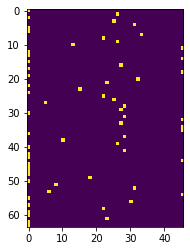

In [112]:
plt.imshow(mask)

In [113]:
select_o = o[mask]

In [114]:
@interact
def scat_plot(channel = (0,o.shape[0]-1,1)):
    plt.figure()
    plt.plot(freqs[:],select_o[channel,:])
#     plt.plot(freqs[:150],s[channel,:150])
    
    
#     plt.axis([None, None, 0, 1])

    plt.title(f'channel {channel}/{o.shape[0]} response')
    plt.xlabel(f'frequencies')
    plt.ylabel('response')

interactive(children=(IntSlider(value=31, description='channel', max=63), Output()), _dom_classes=('widget-int…

In [115]:
def peaks_bandwidth(arr, n,m,level = 1.1):
    out_arr = np.zeros(arr.shape,dtype=bool)
    out_arr[..., n+1:-(n+1)] = True

    for i in range(1, m):
        out_arr[..., n+1:-(n+1)] &= (arr[..., n+1:-(n+1)] > arr[..., n+1-i:-(n+1)-i]) # increasing to the left of the peak      

        out_arr[..., n+1:-(n+1)] &= (arr[..., n+1:-(n+1)] > arr[..., n+1+i:-(n+1)+i])
        
    for i in range(m,n):
        out_arr[..., n+1:-(n+1)] &= (arr[..., n+1:-(n+1)] > level*arr[..., n+1-i:-(n+1)-i]) # increasing to the left of the peak      
        out_arr[..., n+1:-(n+1)] &= (arr[..., n+1:-(n+1)] > level*arr[..., n+1+i:-(n+1)+i])

    return out_arr


In [116]:
p_o = tc.peaks_bandwidth(select_o,n=35,m = 30,level=1.1)

In [117]:
p_o.sum()

337

In [118]:
@interact
def plot(channel = (0,o.shape[0],1)):
    n=1500
    plt.figure()
    plt.plot(freqs[:n],select_o[channel,:n])
    plt.plot(freqs[:n],p_o[channel,:n])
    
#     plt.axis([None, None, m, M])

    plt.title(f'channel {channel}/{select_o.shape[0]} response\n Peaks at {freqs[:n][p_o[channel,:n]]}')
    plt.xlabel(f'frequencies')
    plt.ylabel('response')

interactive(children=(IntSlider(value=32, description='channel', max=64), Output()), _dom_classes=('widget-int…

(array([19., 18.,  8., 10.,  6.,  4., 11.,  2.,  8.,  3.,  5.,  6.,  9.,
         2.,  1.,  4.,  4.,  2.,  0.,  3.,  2.,  1.,  0.,  0.,  1.,  3.,
         0.,  0.,  2.,  0.,  1.]),
 array([1.02880658, 1.10810465, 1.18740272, 1.26670078, 1.34599885,
        1.42529691, 1.50459498, 1.58389305, 1.66319111, 1.74248918,
        1.82178724, 1.90108531, 1.98038338, 2.05968144, 2.13897951,
        2.21827758, 2.29757564, 2.37687371, 2.45617177, 2.53546984,
        2.61476791, 2.69406597, 2.77336404, 2.8526621 , 2.93196017,
        3.01125824, 3.0905563 , 3.16985437, 3.24915243, 3.3284505 ,
        3.40774857, 3.48704663]),
 <a list of 31 Patch objects>)

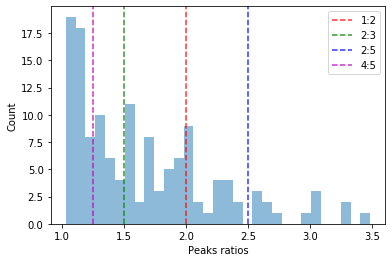

In [124]:
rat = tc.all_peaks_ratios(p_o,freqs,max_n_peaks = 10)
plot_ratios_histogram(1/rat[1/rat<3.5],bins=31)

In [ ]:
p = tc.peaks_bandwidth(o,n=40,m = 35,level=0.7)
p &= o>0.2
rat = tc.all_peaks_ratios(p,freqs,max_n_peaks = 10)
tc.plot_ratios_histogram(1/rat[1/rat<6.2],bins=60,r=[1,2,3,4,5])
len(rat)
plt.savefig(os.path.join(fig_save_folder,"3-2ndlayerdecoder-ratios-distrib-speechlogspec3.pdf"))

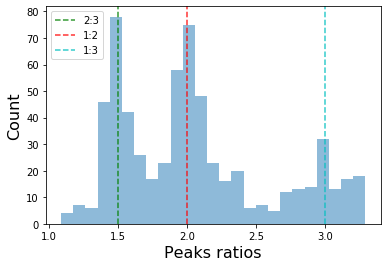

In [54]:
p = tc.peaks_bandwidth(r,n=50,m = 45,level=0.8)
p &= r>0.6
rat = tc.all_peaks_ratios(p,freqs,max_n_peaks = 20)
tc.plot_ratios_histogram(1/rat[1/rat<3.3],bins=25,r=[2,3,5])
len(rat)
plt.xlabel('Peaks ratios',fontsize=16)
plt.ylabel('Count',fontsize=16)
plt.savefig(os.path.join(fig_save_folder,"79-code-ratios-distrib-speechlogspec5.pdf"))

Text(0, 0.5, 'Count')

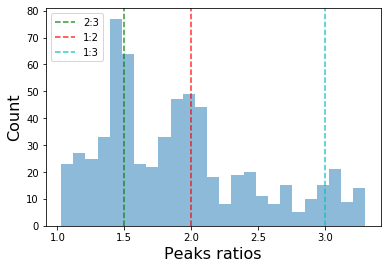

In [78]:
p_mf = tc.peaks_bandwidth(r_mf,n=40,m = 35,level=0.8)
p_mf &= r_mf>0.6
rat_mf = tc.all_peaks_ratios(p_mf,freqs,max_n_peaks = 20)
tc.plot_ratios_histogram(1/rat_mf[1/rat_mf<3.3],bins=25,r=[2,3,5])
len(rat_mf)
plt.xlabel('Peaks ratios',fontsize=16)
plt.ylabel('Count',fontsize=16)
# plt.savefig(os.path.join(fig_save_folder,"79-code-ratios-distrib-speechlogspec5.pdf"))

In [49]:
(p.sum(axis=-1)==1).sum()

200

In [91]:
channel = 1
pos = 2
n = 60
m = 40
l = 0.5
curve = r[channel,pos]
p = tc.peaks_bandwidth(r,n=n,m = m,level=l)

p_ = p[channel,pos]
thres = np.zeros(curve.shape[0])
for ind in np.where(p_)[0]:
    thres[ind - n:ind + n] = curve[ind]*l
    thres[ind - m:ind + m] = curve[ind]

In [92]:
thres[np.where(thres == 0)] = np.nan

In [93]:
# %matplotlib notebook

In [112]:
@interact
def plot(channel = (0,r.shape[0],1),pos = (0,r.shape[1],1)):
    
    n = 80
    m = 40
    l = 0.8
    curve = r[channel,pos]
    p = tc.peaks_bandwidth(r,n=n,m = m,level=l)

    p_ = p[channel,pos]
    thres = np.zeros(curve.shape[0])
    for ind in np.where(p_)[0]:
        thres[ind - n:ind + n] = curve[ind]*l
        thres[ind - m:ind + m] = curve[ind]
    thres[np.where(thres == 0)] = np.nan
    n=1000
    plt.figure()
    plt.plot(freqs[:n],r[channel,pos,:n],label='tuning curve',color='k')
    plt.plot(freqs[:n],r[channel,pos,:n]*p[channel,pos,:n],label='detected peaks',color='gray')
    plt.plot(freqs[:n],thres[:n],color='k',linestyle='dashed',label='bandwidth')
#     plt.plot(freqs[:n],p[channel,pos,:n])

    plt.title(f'channel {channel}/{o.shape[0]} response\n Peaks at {freqs[:n][p[channel,pos,:n]]}')
    plt.xlabel(f'frequencies')
    plt.ylabel('response')
    plt.legend()
    plt.savefig(os.path.join(fig_save_folder,f"4-Example-tc-bandwidth-c{channel}-p{pos}.pdf"))

interactive(children=(IntSlider(value=32, description='channel', max=64), IntSlider(value=6, description='pos'…

interactive(children=(IntSlider(value=32, description='channel', max=64), IntSlider(value=23, description='pos…

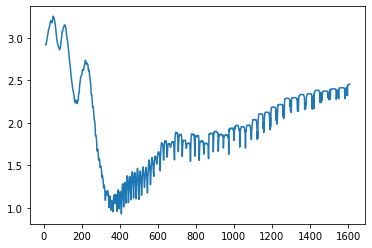

In [90]:
@interact
def plot(channel = (0,o.shape[0],1),pos = (0,o.shape[1],1)):
    n=5000
    plt.figure()
    plt.plot(freqs[:n],o[channel,pos,:n])
    plt.plot(freqs[:n],o[channel,pos,:n].max()*p[channel,pos,:n])
#     plt.plot(freqs[:n],thres[:n])


    plt.title(f'channel {channel}/{select_o.shape[0]} response\n Peaks at {freqs[:n][p[channel,pos,:n]]}')
    plt.xlabel(f'frequencies')
    plt.ylabel('response')

861

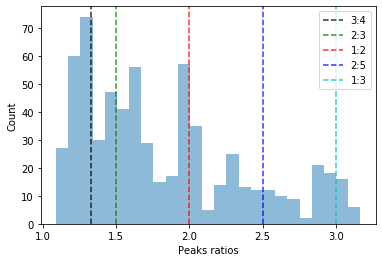

In [244]:
p = tc.peaks_bandwidth(r,n=100,m = 30,level=0.7)
p&= r >0.2
rat = tc.all_peaks_ratios(p,freqs,max_n_peaks = 40)
tc.plot_ratios_histogram(1/rat[1/rat<3.2],bins=25,r=[1,2,3,4,5])
# plt.savefig(os.path.join(fig_save_folder,"3-code-ratios-distrib-speechlogspec1.pdf"))
len(rat)

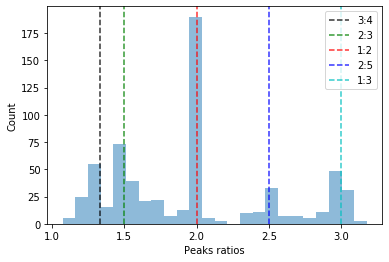

In [216]:
p = tc.peaks_bandwidth(o,n=100,m = 30,level=0.7)
p&= o >0.15
rat = tc.all_peaks_ratios(p,freqs,max_n_peaks = 40)
tc.plot_ratios_histogram(1/rat[1/rat<3.2],bins=24,r=[1,2,3,4,5])
plt.savefig(os.path.join(fig_save_folder,"3-decode-ratios-distrib-speechlogspec.pdf"))

In [303]:
channel = 29
pos = 10
n = 60
m = 20
l = 1.4
curve = r[channel,pos]
p_ = p[channel,pos]
thres = np.zeros(curve.shape[0])
for ind in np.where(p_)[0]:
    thres[ind - n:ind + n] = curve[ind]/l
    thres[ind - m:ind + m] = curve[ind]
    
@interact
def plot(channel = (0,r.shape[0],1),pos = (0,r.shape[1],1)):
    n=5000
    plt.figure()
    plt.plot(freqs[:n],r[channel,pos,:n])
    plt.plot(freqs[:n],r[channel,pos,:n].max()*p[channel,pos,:n])
#     plt.plot(freqs[:n],thres[:n])


    plt.title(f'channel {channel}/{r.shape[0]} response\n Peaks at {freqs[:n][p[channel,pos,:n]]}')
    plt.xlabel(f'frequencies')
    plt.ylabel('response')

interactive(children=(IntSlider(value=32, description='channel', max=64), IntSlider(value=6, description='pos'…

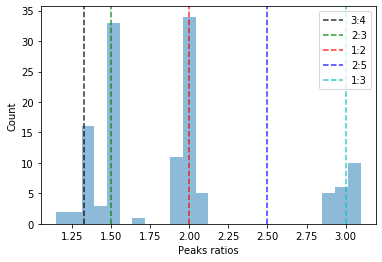

In [214]:
p = tc.peaks_bandwidth(o2,n=80,m = 20,level=0.6)
p&= o2>0.0
rat = tc.all_peaks_ratios(p,freqs,max_n_peaks = 30)
tc.plot_ratios_histogram(1/rat[1/rat<3.2],bins=24,r=[1,2,3,4,5])
plt.savefig(os.path.join(fig_save_folder,"3-out-ratios-distrib-speechlogspec.pdf"))

In [ ]:
@interact
def viz_in_out(i=(0,x.shape[0]-1,1)):
    
    f, axarr = plt.subplots(1,2,figsize=(10,10))
    axarr[0].imshow(x[i,0].cpu().numpy())
    axarr[1].imshow(out[i,0].cpu().numpy())
    print(x[i].max())
    print(out[i].max())

In [56]:
import seaborn as sns

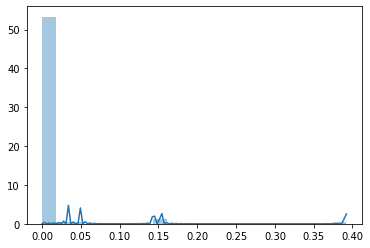

In [57]:
sns.distplot(r.reshape(-1,1997).max(axis=1))

In [ ]:
r.max(axis=1).shape

In [224]:
def peaks(arr, n, threshold=None, percentile=80):
    out_arr = np.zeros(arr.shape,dtype=bool)
    if threshold is None and percentile is not None:
        print(percentile)
        # find threshold from distribution percentile
        threshold=np.percentile(arr[arr>0.01], percentile)
    if threshold is not None:
        print(f'threshold:{threshold}')
        out_arr[..., n+1:-(n+1)]=arr[..., n+1:-(n+1)] > threshold
    else:
        out_arr[..., n+1:-(n+1)] = True
    for i in range(1, n):
        out_arr[..., n+1:-(n+1)] &= (arr[..., n+1:-(n+1)] > arr[..., n+1-i:-(n+1)-i])
        out_arr[..., n+1:-(n+1)] &= (arr[..., n+1:-(n+1)] > arr[..., n+1+i:-(n+1)+i])
    return out_arr


def plot_ratios_histogram(ratios,bins=25,alpha=0.5,save_file=None,xlabel='Peaks ratios', r = [0,1,2,3,4,5]):
    plt.figure()
    ret = plt.hist(ratios,bins=bins,alpha = alpha)
    plt.xlabel(xlabel)
    plt.ylabel('Count')
    
    if ratios[0]<1:        
        plt.axvline(x=0.5,color = 'r',linestyle = '--', alpha = 0.8,label='1:2')
        plt.axvline(x=0.66,color= 'g',linestyle = '--', alpha = 0.8,label='2:3')
        plt.axvline(x=0.4,color= 'b',linestyle = '--', alpha = 0.8,label='2:5')
        plt.axvline(x=0.8,color= 'm',linestyle = '--', alpha = 0.8,label='4:5')
        plt.axvline(x=0.33,color= 'k',linestyle = '--', alpha = 0.8,label='1:3')

        
    else:
        if 0 in r:
            plt.axvline(x=1.25,color= 'm',linestyle = '--', alpha = 0.8,label='4:5')
        if 1 in r:
            plt.axvline(x=1.33,color= 'k',linestyle = '--', alpha = 0.8,label='3:4')
        if 2 in r:
            plt.axvline(x=1.5,color= 'g',linestyle = '--', alpha = 0.8,label='2:3')
        if 3 in r:
            plt.axvline(x=2,color = 'r',linestyle = '--', alpha = 0.8,label='1:2')
        if 4 in r:
            plt.axvline(x=2.5,color= 'b',linestyle = '--', alpha = 0.8,label='2:5')
        if 5 in r:
            plt.axvline(x=3,color= 'k',linestyle = '--', alpha = 0.8,label='1:3')
        

    plt.legend()
    if save_file:
        plt.savefig(save_file)
        plt.close()
    return ret

In [61]:
# norm_r = r/r.max(axis=-1)[:,None]
n=-1
r2 = r[...,:n]
p = peaks(r2,n=10,percentile=None)
p &= r2>(1.2*r2[...,-1][:,:,None])

In [95]:
p = peaks(r,n=30,percentile = 80)
p &= r > 0.8

80
threshold:0.27678146958351135


In [77]:
po = peaks(o,n=20,percentile = None)

In [56]:
@interact
def plot(channel = (0,r.shape[0],1),pos = (0,r.shape[1],1)):
    n=1500
    plt.figure()
    plt.plot(freqs[:n],r[channel,pos,:n])
    plt.plot(freqs[:n],p[channel,pos,:n])
    
#     plt.axis([None, None, m, M])

    plt.title(f'channel {channel}/{r.shape[0]} response\n Peaks at {freqs[:n][p[channel,pos,:n]]}')
    plt.xlabel(f'frequencies',fontsize=16)
    plt.ylabel('response',fontsize=16)

interactive(children=(IntSlider(value=32, description='channel', max=64), IntSlider(value=6, description='pos'…

In [78]:
@interact
def plot(channel = (0,o.shape[0],1),pos = (0,o.shape[1],1)):
    n=1500
    plt.figure()
    plt.plot(freqs[:n],o[channel,pos,:n])
    plt.plot(freqs[:n],po[channel,pos,:n])
    
#     plt.axis([None, None, m, M])

    plt.title(f'channel {channel}/{o.shape[0]} response\n Peaks at {freqs[:n][po[channel,pos,:n]]}')
    plt.xlabel(f'frequencies')
    plt.ylabel('response')

interactive(children=(IntSlider(value=16, description='channel', max=32), IntSlider(value=96, description='pos…

In [97]:
ratios = tc.all_peaks_ratios(peaks_arr=p,freqs_arr=freqs,max_n_peaks=30)

(array([1496., 1838., 1348., 1095., 1013.,  621.,  789.,  642.,  529.,
         492.,  569.,  512.,  363.,  411.,  449.,  473.,  297.,  400.,
         250.,  229.,  310.,  305.,  233.,  209.,  198.,  302.,  145.,
         284.,  149.,  255.,  151.]),
 array([1.02071197, 1.08449818, 1.14828438, 1.21207059, 1.27585679,
        1.33964299, 1.4034292 , 1.4672154 , 1.5310016 , 1.59478781,
        1.65857401, 1.72236022, 1.78614642, 1.84993262, 1.91371883,
        1.97750503, 2.04129123, 2.10507744, 2.16886364, 2.23264985,
        2.29643605, 2.36022225, 2.42400846, 2.48779466, 2.55158086,
        2.61536707, 2.67915327, 2.74293948, 2.80672568, 2.87051188,
        2.93429809, 2.99808429]),
 <a list of 31 Patch objects>)

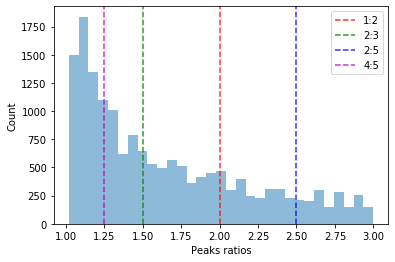

In [98]:
plot_ratios_histogram((1/ratios)[(1/ratios)<3],bins = 31)

In [85]:
ratioso = tc.all_peaks_ratios(peaks_arr=po,freqs_arr=freqs,max_n_peaks=5)

(array([ 66.,  33.,  38.,  55.,  28., 156.,  98.,  44.,  24.,  16.,  25.,
         12.,  17.,  20.,  14.,  34.,  12.,   4.,   8.,  21.,  50.,  73.,
         26.,   2.,   9.,  19.,  17.,  11.,   6.,   2.,   9.]),
 array([1.15008881, 1.20937704, 1.26866527, 1.3279535 , 1.38724173,
        1.44652996, 1.50581819, 1.56510642, 1.62439465, 1.68368288,
        1.74297111, 1.80225934, 1.86154757, 1.92083581, 1.98012404,
        2.03941227, 2.0987005 , 2.15798873, 2.21727696, 2.27656519,
        2.33585342, 2.39514165, 2.45442988, 2.51371811, 2.57300634,
        2.63229457, 2.6915828 , 2.75087103, 2.81015926, 2.86944749,
        2.92873572, 2.98802395]),
 <a list of 31 Patch objects>)

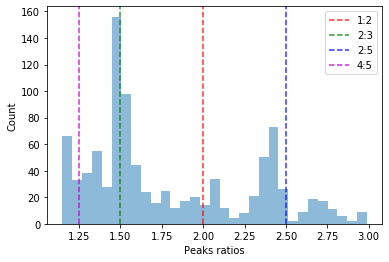

In [88]:
plot_ratios_histogram((1/ratioso)[((1/ratioso)<3) & ((1/ratioso)>1.15) ],bins = 31)

In [ ]:
len(ratios)

In [67]:
a = r[(r>0).sum(axis=1)>0]

In [69]:
@interact
def scat_plot(channel = (0,a.shape[0]-1,1)):
    plt.figure()
    plt.plot(freqs,r[channel])
#     plt.axis([None, None, m, M])

    plt.title(f'channel {channel}/{a.shape[0]} response ')
    plt.xlabel(f'frequencies')
    plt.ylabel('response')

interactive(children=(IntSlider(value=12, description='channel', max=24), Output()), _dom_classes=('widget-int…

# Single peaked units - Modulation

In [84]:
idx_sp = p.sum(axis=-1)==1
r_sp = r[p.sum(axis=-1)==1]
r_mf_sp = r_mf[p.sum(axis=-1)==1]
p_sp = p[p.sum(axis=-1)==1]

In [85]:
idx_sp.shape

(64, 12)

In [86]:
sp_pos = np.array(np.where(idx_sp)).T

In [87]:
sp_pos.shape

(200, 2)

interactive(children=(IntSlider(value=99, description='i', max=199), Output()), _dom_classes=('widget-interact…

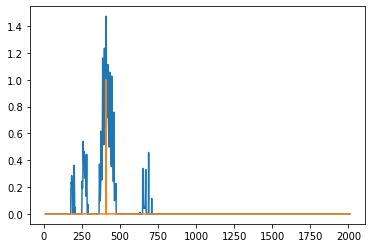

In [89]:
@interact
def plot(i = (0,sp_pos.shape[0]-1,1 )):
    plt.plot(freqs[:2000],r[tuple(sp_pos[i])][:2000])
    plt.plot(freqs[:2000],p[tuple(sp_pos[i])][:2000])
    print(freqs[p[tuple(sp_pos[i])]])

In [298]:
r[tuple(sp_pos[0])].shape

(2100,)

In [295]:
sp_pos[0]

array([0, 3])

In [297]:
r[(0,3)].shape

(2100,)

In [294]:
r.shape

(64, 12, 2100)

In [275]:
cfs = np.concatenate([freqs[p_sp[i]] for i in range(p_sp.shape[0])])

In [222]:
cfs.shape

(155,)

In [223]:
import seaborn as sns

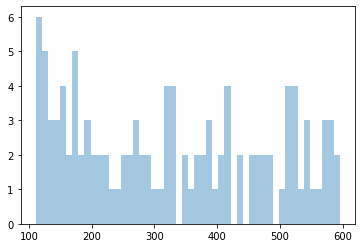

In [251]:
sns.distplot(cfs[cfs<600],bins = 50,kde=False)

In [248]:
cfs[(cfs>175)&(cfs < 190)]

array([177, 187, 177, 183])

In [276]:
cfs[(cfs>=310)&(cfs <= 330)]

array([316, 325, 324, 316, 318, 325])

In [63]:
p_sp.shape

(155, 2100)

In [60]:
p_sp.shape

(155, 2100)

In [61]:
freqs.shape

(2100,)

## CF at 187Hz

### Two-tone stimuli

In [227]:
from common.spectrogram import Spectrogrammer

In [228]:
window = 6000
sr = 44100
n_octaves = 10
k_per_octave = 24
low = 20
stride = 168 # To obtain 250frame per sec

spec_trans = Spectrogrammer(window=window,sr = sr,n_octaves = n_octaves,k_per_octave = k_per_octave,low=low,stride = stride)

In [229]:
from common import stimulus

In [230]:
cf_tone = stimulus.pure_tone(freq=187,window=8820,sr=44100)

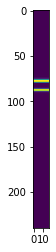

In [231]:
plt.imshow(spec_trans((cf_tone +stimulus.pure_tone(freq=250,window=8820,sr=44100) )[None,:])[0])

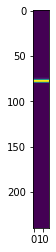

In [232]:
plt.imshow(spec_trans(cf_tone[None,:])[0])

In [233]:
resp_code = []
frequencies = [] 
outs = []
ins = []

encoder.eval()
decoder.eval()

for batch in range(100):
    spec_batch = []
    for f in range(20+batch*50,70+batch*50,1):
        frequencies.append(f)
        tone = 0.5 * (cf_tone + stimulus.pure_tone(freq=f,window=8820,sr=44100))
        
        spec_batch.append(spec_trans(tone[None,:]))

    spec_batch = torch.stack(spec_batch)[:,0]
    x = spec_batch.type(torch.FloatTensor).unsqueeze(1).to(device)
    x = x[...,:232,0:10]
    M = x.max(axis=2).values.max(axis=1).values[:,None,None]
    m = x.min(axis=2).values.min(axis=1).values[:,None,None]
    x = (x-m)/(M-m)

    code = encoder.layers[0](x)     
    #     code = torch.relu(code)

    code = encoder.layers[1](code)
    code = torch.relu(code)

    code = encoder.layers[2](code)
    #     code = torch.relu(code)

    code = encoder.layers[3](code)
    code = torch.relu(code)

    resp_code.append(code[...,0].cpu().data.numpy())


    out = decoder.layers[0](code)
    out = torch.relu(out)

    out = decoder.layers[1](out)
    out = torch.relu(out)

    outs.append(out[...,0].cpu().data.numpy())

    out = decoder.layers[2](out)
    out = torch.relu(out)

    out = decoder.layers[3](out)
    out = torch.sigmoid(out)

    outs2.append(out[...,0].cpu().data.numpy())


    ins.append(x[...,0].cpu().data.numpy())
#     if i == 20 :
#         break

            
s_2tones = np.vstack(ins)       

s_2tones = np.moveaxis(s_2tones,0,-1)

r_2tones = np.vstack(resp_code)
o_2tones = np.vstack(outs)
o2_2tones = np.vstack(outs2)

freqs2tones = np.array(frequencies)

r_2tones = np.moveaxis(r_2tones,0,-1)
o_2tones = np.moveaxis(o_2tones,0,-1)
o2_2tones = np.moveaxis(o2_2tones,0,-1)

In [126]:
x.shape

torch.Size([50, 1, 232, 0])

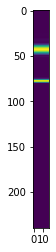

In [123]:
plt.imshow(spec_batch[49,0])

In [129]:
r_2tones.shape

(64, 12, 10000)

In [ ]:
plt.imshow()

In [178]:
idx = np.where(idx_sp)

In [148]:
idx[:,0]

TypeError: tuple indices must be integers or slices, not tuple

In [234]:
idx_187 = [[idx[0][i],idx[1][i]] for i in np.where((cfs == 186) |(cfs == 187))[0]]

In [235]:
idx_187

[[4, 11], [5, 5], [8, 5], [35, 2], [43, 5], [45, 9], [58, 3]]

In [236]:
r_2tones.shape

(64, 12, 5000)

In [237]:
freqs2tones.shape

(5000,)

In [238]:
@interact
def plot(i=(0,len(idx_187),1)):
    plt.plot((freqs2tones/187)[:1000],r_2tones[idx_187[i][0],idx_187[i][1],:1000])

interactive(children=(IntSlider(value=3, description='i', max=7), Output()), _dom_classes=('widget-interact',)…

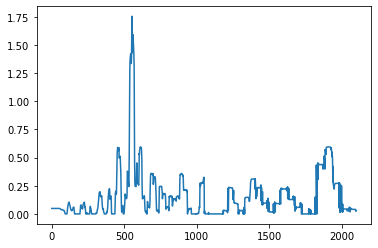

In [240]:
i = 0
plt.plot(r[idx_187[i][0],idx_187[i][1]])

In [164]:
idx_187[i,0],idx_187[i,0]

TypeError: list indices must be integers or slices, not tuple

## CF = 320Hz

In [256]:
cf_tone = stimulus.pure_tone(freq=320,window=8820,sr=44100)

In [257]:
resp_code = []
frequencies = [] 
outs = []
ins = []

encoder.eval()
decoder.eval()

for batch in range(100):
    spec_batch = []
    for f in range(20+batch*50,70+batch*50,1):
        frequencies.append(f)
        tone = 0.5 * (cf_tone + stimulus.pure_tone(freq=f,window=8820,sr=44100))
        
        spec_batch.append(spec_trans(tone[None,:]))

    spec_batch = torch.stack(spec_batch)[:,0]
    x = spec_batch.type(torch.FloatTensor).unsqueeze(1).to(device)
    x = x[...,:232,0:10]
    M = x.max(axis=2).values.max(axis=1).values[:,None,None]
    m = x.min(axis=2).values.min(axis=1).values[:,None,None]
    x = (x-m)/(M-m)

    code = encoder.layers[0](x)     
    #     code = torch.relu(code)

    code = encoder.layers[1](code)
    code = torch.relu(code)

    code = encoder.layers[2](code)
    #     code = torch.relu(code)

    code = encoder.layers[3](code)
    code = torch.relu(code)

    resp_code.append(code[...,0].cpu().data.numpy())


    out = decoder.layers[0](code)
    out = torch.relu(out)

    out = decoder.layers[1](out)
    out = torch.relu(out)

    outs.append(out[...,0].cpu().data.numpy())

    out = decoder.layers[2](out)
    out = torch.relu(out)

    out = decoder.layers[3](out)
    out = torch.sigmoid(out)

    outs2.append(out[...,0].cpu().data.numpy())


    ins.append(x[...,0].cpu().data.numpy())
#     if i == 20 :
#         break

            
s_2tones320 = np.vstack(ins)       

s_2tones320 = np.moveaxis(s_2tones320,0,-1)

r_2tones320 = np.vstack(resp_code)
o_2tones330 = np.vstack(outs)
o2_2tones330 = np.vstack(outs2)

freqs2tones = np.array(frequencies)

r_2tones320 = np.moveaxis(r_2tones320,0,-1)
o_2tones330 = np.moveaxis(o_2tones330,0,-1)
o2_2tones330 = np.moveaxis(o2_2tones330,0,-1)

In [271]:
idx_320 = [[idx[0][i],idx[1][i]] for i in np.where((cfs >= 310) &(cfs <= 330))[0]]

In [94]:
@interact
def plot(i=(0,len(idx_320)-1,1)):
    plt.plot((freqs2tones/320)[:],r_2tones320[idx_320[i][0],idx_320[i][1],:])
#     dis_change =  (r_2tones330[idx_330[i][0],idx_330[i][1]] - r[idx_330[i][0],idx_330[i][1]][])

NameError: name 'idx_320' is not defined

In [268]:
i = 5
r[idx_320[i][0],idx_320[i][1]].shape

(2100,)

In [270]:
np.where(p[idx_320[i][0],idx_320[i][1]])

(array([], dtype=int64),)

In [ ]:
plt.plot()

In [210]:
r_2tones.shape

(64, 12, 5000)

In [205]:
idx_330[i][0],idx_330[i][1]

IndexError: list index out of range

## CF = 344Hz

In [307]:
cf =344#Hz

In [304]:
np.where((cfs<350)&(cfs>330) )

(array([  6,  66,  82, 171]),)

In [305]:
np.where(cfs==cf)

(array([66, 82]),)

In [306]:
r_2tones= {}

In [308]:
cf_tone = stimulus.pure_tone(freq=cf,window=8820,sr=44100)

resp_code = []
frequencies = [] 
outs = []
ins = []

encoder.eval()
decoder.eval()

for batch in range(100):
    spec_batch = []
    for f in range(20+batch*50,70+batch*50,1):
        frequencies.append(f)
        tone = 0.5 * (cf_tone + stimulus.pure_tone(freq=f,window=8820,sr=44100))
        
        spec_batch.append(spec_trans(tone[None,:]))

    spec_batch = torch.stack(spec_batch)[:,0]
    x = spec_batch.type(torch.FloatTensor).unsqueeze(1).to(device)
    x = x[...,:232,0:10]
    M = x.max(axis=2).values.max(axis=1).values[:,None,None]
    m = x.min(axis=2).values.min(axis=1).values[:,None,None]
    x = (x-m)/(M-m)

    code = encoder.layers[0](x)     
    #     code = torch.relu(code)

    code = encoder.layers[1](code)
    code = torch.relu(code)

    code = encoder.layers[2](code)
    #     code = torch.relu(code)

    code = encoder.layers[3](code)
    code = torch.relu(code)

    resp_code.append(code[...,0].cpu().data.numpy())


    out = decoder.layers[0](code)
    out = torch.relu(out)

    out = decoder.layers[1](out)
    out = torch.relu(out)

    outs.append(out[...,0].cpu().data.numpy())

    out = decoder.layers[2](out)
    out = torch.relu(out)

    out = decoder.layers[3](out)
    out = torch.sigmoid(out)

    outs2.append(out[...,0].cpu().data.numpy())


    ins.append(x[...,0].cpu().data.numpy())
#     if i == 20 :
#         break

            
# s_2tones320 = np.vstack(ins)       

# s_2tones320 = np.moveaxis(s_2tones320,0,-1)

r_2tones[cf] = np.vstack(resp_code)
# o_2tones330 = np.vstack(outs)
# o2_2tones330 = np.vstack(outs2)

freqs2tones = np.array(frequencies)

r_2tones[cf] = np.moveaxis(r_2tones[cf],0,-1)
# o_2tones330 = np.moveaxis(o_2tones330,0,-1)
# o2_2tones330 = np.moveaxis(o2_2tones330,0,-1)

In [311]:
r[tuple(sp_pos[66]),p[tuple(sp_pos[66])]]

IndexError: boolean index did not match indexed array along dimension 1; dimension is 12 but corresponding boolean dimension is 2100

In [312]:
p[tuple(sp_pos[66])].shape

(2100,)

In [314]:
r[tuple(sp_pos[66])][p[tuple(sp_pos[66])]]

array([3.7388911], dtype=float32)

In [321]:
idx = 88
dis_rate = (r_2tones[cf][tuple(sp_pos[idx])] - r[tuple(sp_pos[idx])][p[tuple(sp_pos[idx])]][0])/r[tuple(sp_pos[idx])][p[tuple(sp_pos[idx])]][0]

Text(0.5, 0, 'Normalized frequency f/CF, CF = 729Hz')

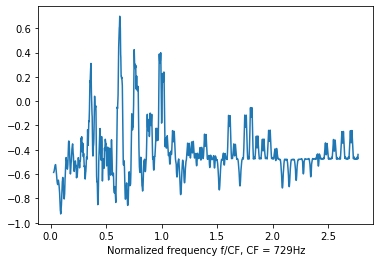

In [326]:
plt.plot(freqs2tones[:2000]/freqs[[p[tuple(sp_pos[idx])]][0]],dis_rate[:2000])
plt.xlabel(f'Normalized frequency f/CF, CF = {freqs[[p[tuple(sp_pos[idx])]][0]][0]}Hz')
plt.ylabel()

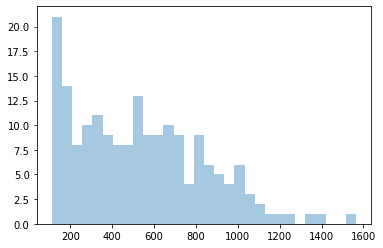

In [329]:
sns.distplot(cfs,bins=30,kde=False)

In [356]:
@interact
def cff(cf = (500,600,1)):
    print(cfs[(cfs<=cf+10) & (cfs >= cf-10)])

interactive(children=(IntSlider(value=550, description='cf', max=600, min=500), Output()), _dom_classes=('widg…

## CF ~ 800Hz

In [345]:
cf =800#Hz
towatch[cf] = np.where((cfs>cf-10)&(cfs<cf+10) )[0]

cf_tone = stimulus.pure_tone(freq=cf,window=8820,sr=44100)

resp_code = []
frequencies = [] 
outs = []
ins = []

encoder.eval()
decoder.eval()

for batch in range(100):
    spec_batch = []
    for f in range(20+batch*50,70+batch*50,1):
        frequencies.append(f)
        tone = 0.5 * (cf_tone + stimulus.pure_tone(freq=f,window=8820,sr=44100))
        
        spec_batch.append(spec_trans(tone[None,:]))

    spec_batch = torch.stack(spec_batch)[:,0]
    x = spec_batch.type(torch.FloatTensor).unsqueeze(1).to(device)
    x = x[...,:232,0:10]
    M = x.max(axis=2).values.max(axis=1).values[:,None,None]
    m = x.min(axis=2).values.min(axis=1).values[:,None,None]
    x = (x-m)/(M-m)

    code = encoder.layers[0](x)     
    #     code = torch.relu(code)

    code = encoder.layers[1](code)
    code = torch.relu(code)

    code = encoder.layers[2](code)
    #     code = torch.relu(code)

    code = encoder.layers[3](code)
    code = torch.relu(code)

    resp_code.append(code[...,0].cpu().data.numpy())


    out = decoder.layers[0](code)
    out = torch.relu(out)

    out = decoder.layers[1](out)
    out = torch.relu(out)

    outs.append(out[...,0].cpu().data.numpy())

    out = decoder.layers[2](out)
    out = torch.relu(out)

    out = decoder.layers[3](out)
    out = torch.sigmoid(out)

    outs2.append(out[...,0].cpu().data.numpy())


    ins.append(x[...,0].cpu().data.numpy())
#     if i == 20 :
#         break

            
# s_2tones320 = np.vstack(ins)       

# s_2tones320 = np.moveaxis(s_2tones320,0,-1)

r_2tones[cf] = np.vstack(resp_code)
# o_2tones330 = np.vstack(outs)
# o2_2tones330 = np.vstack(outs2)

freqs2tones = np.array(frequencies)

r_2tones[cf] = np.moveaxis(r_2tones[cf],0,-1)
# o_2tones330 = np.moveaxis(o_2tones330,0,-1)
# o2_2tones330 = np.moveaxis(o2_2tones330,0,-1)

In [348]:
towatch = {cf:towatch}

In [349]:
@interact
def plot(i = (0,len(towatch)-1,1)):
    idx = tuple(sp_pos[towatch[cf][i]])
    cf_response = r[idx][p[idx]][0]
    dis_change = (r_2tones[cf][idx] - cf_response)/cf_response
    real_cf = freqs[p[idx]][0]
    plt.plot(freqs2tones/real_cf, dis_change)

interactive(children=(IntSlider(value=0, description='i', max=0), Output()), _dom_classes=('widget-interact',)…

In [343]:
sp_pos[towatch[1]]

array([5, 5])

In [ ]:
dis_rate = (r_2tones[cf][idx] - r[idx][p[idx]][0])/r[tuple(sp_pos[idx])][p[tuple(sp_pos[idx])]][0]

## CF = 575Hz

In [359]:
cf =575#Hz
towatch[cf] = np.where((cfs>=cf-10)&(cfs<=cf+10) )[0]

cf_tone = stimulus.pure_tone(freq=cf,window=8820,sr=44100)

resp_code = []
frequencies = [] 
outs = []
ins = []

encoder.eval()
decoder.eval()

for batch in range(100):
    spec_batch = []
    for f in range(20+batch*50,70+batch*50,1):
        frequencies.append(f)
        tone = 0.5 * (cf_tone + stimulus.pure_tone(freq=f,window=8820,sr=44100))
        
        spec_batch.append(spec_trans(tone[None,:]))

    spec_batch = torch.stack(spec_batch)[:,0]
    x = spec_batch.type(torch.FloatTensor).unsqueeze(1).to(device)
    x = x[...,:232,0:10]
    M = x.max(axis=2).values.max(axis=1).values[:,None,None]
    m = x.min(axis=2).values.min(axis=1).values[:,None,None]
    x = (x-m)/(M-m)

    code = encoder.layers[0](x)     
    #     code = torch.relu(code)

    code = encoder.layers[1](code)
    code = torch.relu(code)

    code = encoder.layers[2](code)
    #     code = torch.relu(code)

    code = encoder.layers[3](code)
    code = torch.relu(code)

    resp_code.append(code[...,0].cpu().data.numpy())


    out = decoder.layers[0](code)
    out = torch.relu(out)

    out = decoder.layers[1](out)
    out = torch.relu(out)

    outs.append(out[...,0].cpu().data.numpy())

    out = decoder.layers[2](out)
    out = torch.relu(out)

    out = decoder.layers[3](out)
    out = torch.sigmoid(out)

    outs2.append(out[...,0].cpu().data.numpy())


    ins.append(x[...,0].cpu().data.numpy())
#     if i == 20 :
#         break

            
# s_2tones320 = np.vstack(ins)       

# s_2tones320 = np.moveaxis(s_2tones320,0,-1)

r_2tones[cf] = np.vstack(resp_code)
# o_2tones330 = np.vstack(outs)
# o2_2tones330 = np.vstack(outs2)

freqs2tones = np.array(frequencies)

r_2tones[cf] = np.moveaxis(r_2tones[cf],0,-1)
# o_2tones330 = np.moveaxis(o_2tones330,0,-1)
# o2_2tones330 = np.moveaxis(o2_2tones330,0,-1)

interactive(children=(IntSlider(value=2, description='i', max=5), IntSlider(value=15, description='sigma', max…

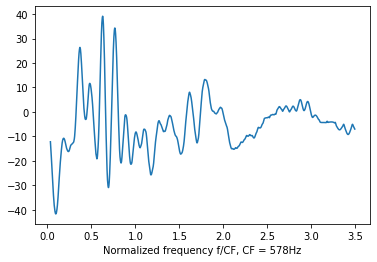

In [379]:
@interact
def plot(i = (0,len(towatch[cf])-1,1),sigma=(0,30),window=(0,100)):
    maxf = 2000
    idx = tuple(sp_pos[towatch[cf][i]])
    cf_response = r[idx][p[idx]][0]
    dis_change = 100*(r_2tones[cf][idx] - cf_response)/cf_response
    real_cf = freqs[p[idx]][0]
#     plt.plot(freqs2tones[:maxf]/real_cf, dis_change[:maxf])
    plt.plot(freqs2tones[:maxf]/real_cf,tc.smooth_curves(dis_change[None,:],window=window,sigma=sigma)[0][:maxf])
    plt.xlabel(f'Normalized frequency f/CF, CF = {freqs[p[idx]][0]}Hz')
    plt.ylabel()

In [365]:
i=0
idx = tuple(sp_pos[towatch[cf][i]])
cf_response = r[idx][p[idx]][0]
dis_change = 100*(r_2tones[cf][idx] - cf_response)/cf_response

In [366]:
dis_change.shape

(5000,)